# Modelling Version 2

### Imports

In [195]:
# Standard library imports
from pathlib import Path
import os

# Third party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report
)

In [196]:
%matplotlib inline
sns.set_style('whitegrid')
sns.set(font_scale=1.2)

### Read in data

In [197]:
data_path = Path('../data')
processed_prem_path = os.path.join(data_path, 'processed', 'processed_prem_fixtures_v2.csv')
fixtures = pd.read_csv(processed_prem_path)

In [198]:
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7396 entries, 0 to 7395
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            7396 non-null   int64  
 1   date                                7396 non-null   object 
 2   season                              7396 non-null   int64  
 3   team_id                             7396 non-null   int64  
 4   team_name                           7396 non-null   object 
 5   opposition_id                       7396 non-null   int64  
 6   opposition_name                     7396 non-null   object 
 7   scored                              7396 non-null   float64
 8   conceded                            7396 non-null   float64
 9   relative_score                      7396 non-null   float64
 10  league_position                     7396 non-null   int64  
 11  opposition_league_position          7396 no

## Create features

First, let's remove any fixtures where there is no head to head data available (as the teams haven't played before in the data I have collected).

In [199]:
fixtures = fixtures[fixtures['average_hth_points'].notnull()]

As many of the feautures are still reliant on gathering information from the season the fixture is played in I will remove the first 4 fixtures so the model has access to more accurate information.

In [200]:
# Get rid of early season games
fixtures = fixtures[fixtures['games_played'] > 3]
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5778 entries, 40 to 7395
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            5778 non-null   int64  
 1   date                                5778 non-null   object 
 2   season                              5778 non-null   int64  
 3   team_id                             5778 non-null   int64  
 4   team_name                           5778 non-null   object 
 5   opposition_id                       5778 non-null   int64  
 6   opposition_name                     5778 non-null   object 
 7   scored                              5778 non-null   float64
 8   conceded                            5778 non-null   float64
 9   relative_score                      5778 non-null   float64
 10  league_position                     5778 non-null   int64  
 11  opposition_league_position          5778 n

Again, I want to calculate relative statistics between some of the features to find the difference between the teams.

In [201]:
def get_relative_statistic(fixtures, feature, lower_better):
    """
    Create relative statistics columns from features about each team in
    fixture. Params:
    - fixtures: pd.DataFrame
    - feature: Statistic to calculate relative statistics from.
    - lower_better: Bool, True if a lower value is better for the statistic.
    """
    # Get team and opposition stats
    columns = {'team': feature, 'opposition': '_'.join(['opposition', feature])}
    
    # Reset index to avoid concat issue
    new_fixtures = fixtures.reset_index(drop=True)
    
    # Calculate relative stat
    sign = -1 if lower_better else 1
    relative_stat = sign * (fixtures[columns['team']] - fixtures[columns['opposition']])
    relative_stat = relative_stat.rename('_'.join(['relative', feature]))

    return pd.concat([fixtures, relative_stat], axis=1)

In [202]:
lower_better_statistics = [
    '_'.join([prefix, 'average_conceded'])
    for prefix in ('HA', 'season')
]
lower_better_statistics.append('league_position')
higher_better_statistics = [
    '_'.join([prefix, stat])
    for prefix in ('HA', 'season')
    for stat in ('average_scored', 'average_points', 'form')
]
for stat in higher_better_statistics:
    fixtures = get_relative_statistic(fixtures, stat, False)
for stat in lower_better_statistics:
    fixtures = get_relative_statistic(fixtures, stat, True)

Again, I will create interaction terms for to measure the interaction between attack and defence based on each teams average scored and conceded. I will create terms for teams scored/conceded when playing at home/away and also overall.

In [203]:
# Interaction terms
fixtures['HA_attack_defence_interaction'] = (
    fixtures['HA_average_scored'] * fixtures['opposition_HA_average_conceded'])
fixtures['HA_defence_attack_interaction'] = (
    fixtures['HA_average_conceded'] * fixtures['opposition_HA_average_scored'])
fixtures['season_attack_defence_interaction'] = (
    fixtures['season_average_scored'] * fixtures['opposition_season_average_conceded'])
fixtures['season_defence_attack_interaction'] = (
    fixtures['season_average_conceded'] * fixtures['opposition_season_average_scored'])

We can again create relative statistics between these to highlight the difference between the two teams.

In [204]:
fixtures['relative_HA_att_def_interaction'] = (
    fixtures['HA_attack_defence_interaction'] - fixtures['HA_defence_attack_interaction'])
fixtures['relative_season_att_def_interaction'] = (
    fixtures['season_attack_defence_interaction'] - fixtures['season_defence_attack_interaction'])

## EDA

Now the target is the 'win' column, so first I will look at the variance of the target.

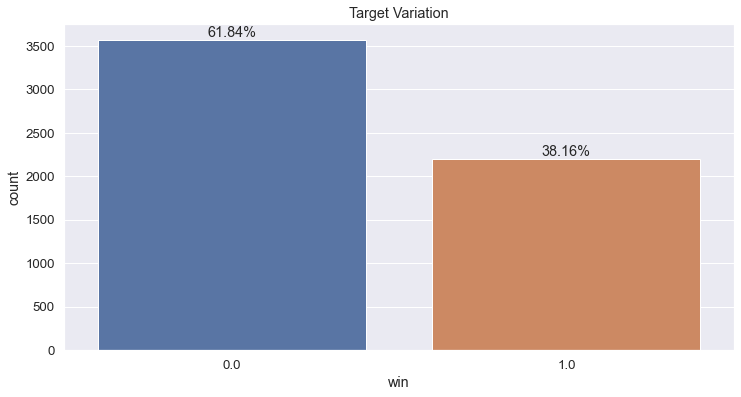

In [205]:
plt.figure(figsize=(12,6))
ax = sns.countplot(fixtures['win'])
no_fixtures = len(fixtures)
plt.title('Target Variation')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_height()
    ax.annotate(f'{100*y/no_fixtures:.2f}%', (x.mean(), y), ha='center', va='bottom')

As each fixture is repeated twice, the difference can be accounted for by the number of draws. 

Let's look at how the 'home' indicator effects the distribution of wins.

Text(64.5, 0.5, 'Home')

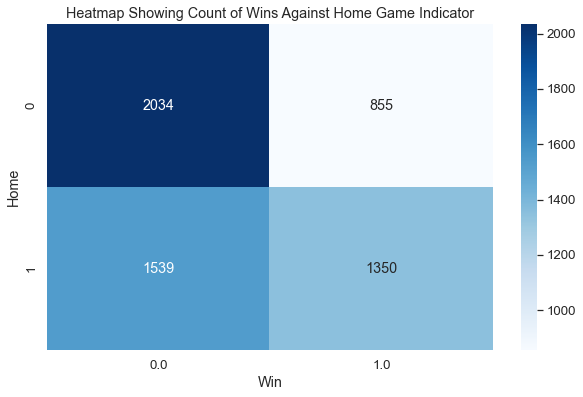

In [206]:
home_win_count = fixtures.pivot_table(index='home', columns='win', values='team_id', aggfunc='count')
plt.figure(figsize=(10, 6))
plt.title('Heatmap Showing Count of Wins Against Home Game Indicator')
sns.heatmap(home_win_count, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Win')
plt.ylabel('Home')

The heatmap shows that winning is more likley when playing at home and losing/drawing is more likley when playing away, therefore this will be a useful feature for prediction.

Now let's look if any of the features help to distinguish which team wins, again we will use the relative columns.

In [207]:
feature_cols = [
    'relative_HA_average_scored',
    'relative_season_average_scored',
    'relative_HA_average_conceded',
    'relative_season_average_conceded',
    'relative_HA_average_points',
    'relative_season_average_points',
    'relative_HA_form',
    'relative_season_form',
    'relative_HA_att_def_interaction',
    'relative_season_att_def_interaction',
    'average_hth_points',
    'average_hth_relative_score',
    'relative_league_position',
]
target_col = 'win'

Now we can visualise any difference in distribution of the features based on the target.

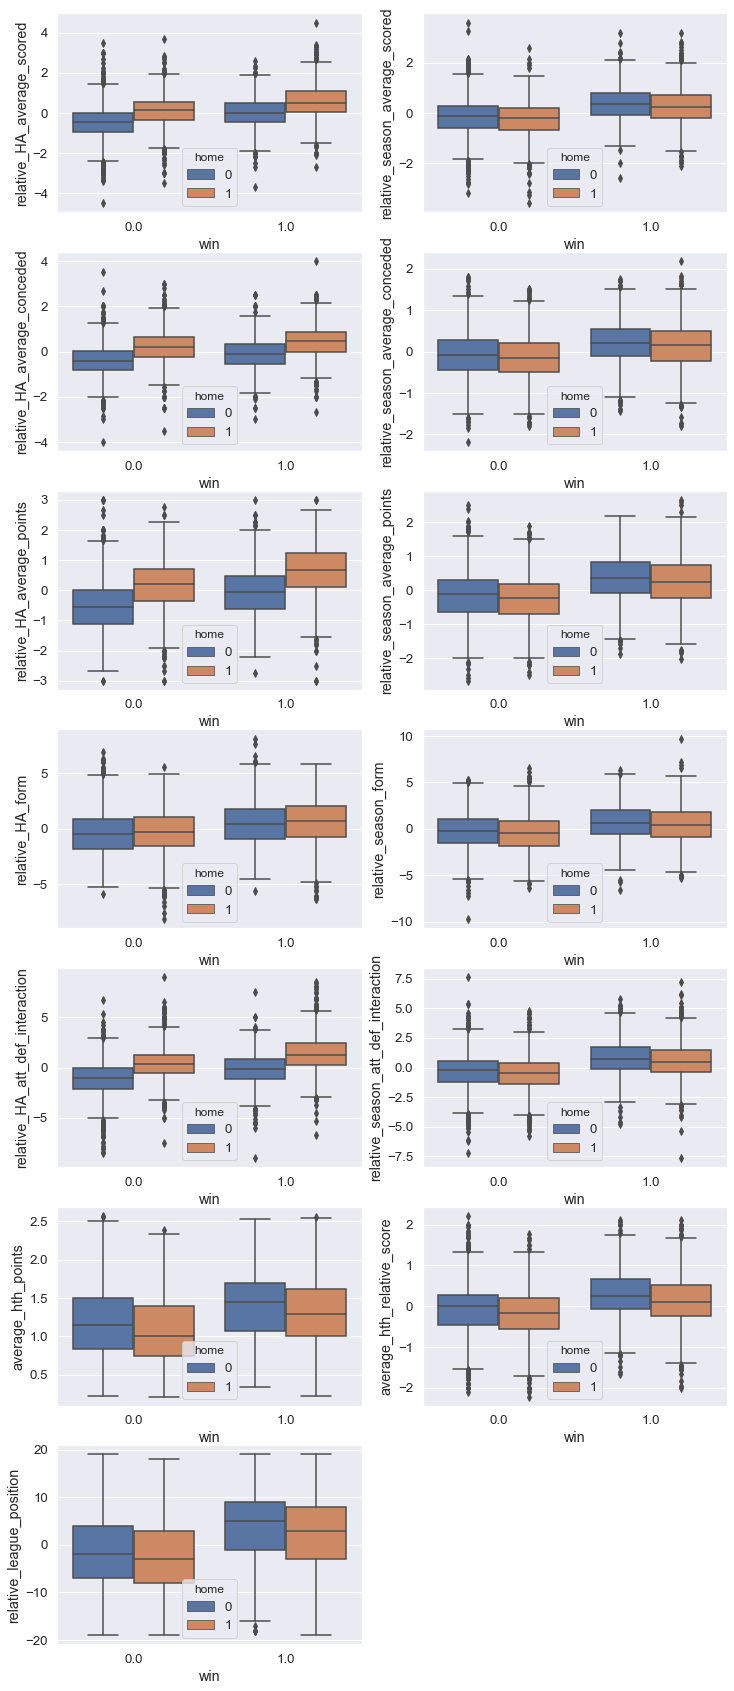

In [209]:
fig, axes = plt.subplots(7, 2, figsize=(12, 30))
fig.delaxes(axes[6, 1])

for ax, feature in enumerate(feature_cols):
    sns.boxplot(x=fixtures['win'], y=fixtures[feature], orient='v', ax=axes[ax//2, ax%2])

## Predict relative score

## Win classifier